## Six-bar Mechanism Balancing

In [1]:
from BetaShF import ShF
from BetaShM import ShM 
import numpy as np 
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from cnsg_differential_evolution import cnsg_differential_evolution

### Contraints

$-0.16m <= x_{cn},y_{cn} <= 0.16m$

$0.005m <= t_{cn} <= 0.04m$

### Objective Function

In [2]:
def objective_function(s, ShF, ShM): #c is a constant that distributes the weight among the functions.
    c = 0.5
    return c*ShF(s) + c*ShM(s)

### Gradient Descent

In [3]:

eps = 1e-5
def Vf(X,ShF,ShM,f):
    n = len(X)
    G = np.zeros((n),float)
    incX = np.zeros((n),float)
    for i in range(n):
        incX[i] = eps
        G[i] = (f(X+incX,ShF, ShM)-f(X,ShF, ShM))/eps
        incX[i] = 0
    return G

def VfTd(X,ShF, ShM,d,f):
    return (f(X+eps*d,ShF, ShM,)-f(X,ShF, ShM,))/eps

def V2f(X,ShF,ShM,f):
    n = len(X)
    H = np.zeros((n,n),float)
    incX = np.zeros((n),float)
    for i in range(n):
        incX[i] = eps
        H[:,i] = (Vf(X+incX,ShF,ShM,f)-Vf(X,ShF,ShM,f))/eps
        incX[i] = 0
    return H

def V2fTd(X,ShF, ShM,d,f):
    return (Vf(X+eps*d,ShF, ShM,f)-Vf(X,ShF, ShM,f))/eps
    
# X = np.array([2,3])
# d = np.array([5,1])


# print("P_k: ", d)

# print('f:',objective_function(bestSol.x,ShF, ShM))
# print('Vf:',Vf(bestSol.x, ShF, ShM,objective_function))
# print('V2f:',V2f(bestSol.x, ShF, ShM,objective_function))
# print('VfTd:',VfTd(bestSol.x, ShF, ShM,d,objective_function))
# print('V2fTd:',V2fTd(bestSol.x, ShF, ShM,d,objective_function))

In [4]:
def calculate_d(X):
    return -Vf(X,ShF,ShM,objective_function)/np.linalg.norm(Vf(X, ShF, ShM, objective_function))

In [5]:
def gradiente_conjugado(X0,ShF,ShM,f,MaxIter=1000,eps=1e-5):
    k=0
    X = X0
    G = Vf(X,ShF, ShM,f)
    normaGradiente = np.linalg.norm(G)
    P = -G
    fit = f(X, ShF, ShM)
    while(k<=MaxIter and normaGradiente>=eps):
        Ap = V2fTd(X,ShF, ShM,P,f)
        alpha = np.dot(-P,G) / np.dot(P,Ap)
        X = X + alpha*P
        G_ = np.copy(G)
        G = G + alpha*Ap
        normaGradiente = np.linalg.norm(G)
        B = -np.dot(G,G)/np.dot(G_,G_)
        P = -G + B*P
        k = k+1
        print("**: ",k,f(X,ShF,ShM))
        if f(X,ShF,ShM) >= fit:
            break
        fit = f(X,ShF,ShM)
    return X

In [6]:
def gradient_descent(x,d, Vf, VfTd, V2f, V2fTd):
    a_k = 0.01
    max_iter = 3
    k=0
    while(k < max_iter and np.linalg.norm(Vf(x, ShF, ShM,objective_function)) > eps ):
        print("#---->",k)
        # Calculate step size a_k
        
        d = -Vf(x,ShF,ShM,objective_function)/np.linalg.norm(Vf(x, ShF, ShM, objective_function))
        a_k = (-VfTd(x,ShF, ShM,d,objective_function) * d ) / V2f(x,ShF, ShM,objective_function) * d # P = d
       
        # Calculate the direction P_k
        x = x + a_k*d
        k+=1
        # print("a_k: ",a_k)
        # break
    return x

### Differential Evolution

In [7]:
# Bounds for each variable
nVar = 5
bounds = []
for i in range(1,nVar*3+1):
    if(i%3==0): bounds.append([0.005,0.04])
    else: bounds.append([-0.16, 0.16])
bounds = np.array(bounds)
print('bounds',bounds)


bounds [[-0.16   0.16 ]
 [-0.16   0.16 ]
 [ 0.005  0.04 ]
 [-0.16   0.16 ]
 [-0.16   0.16 ]
 [ 0.005  0.04 ]
 [-0.16   0.16 ]
 [-0.16   0.16 ]
 [ 0.005  0.04 ]
 [-0.16   0.16 ]
 [-0.16   0.16 ]
 [ 0.005  0.04 ]
 [-0.16   0.16 ]
 [-0.16   0.16 ]
 [ 0.005  0.04 ]]


In [8]:
s=bounds[:,0]
r = objective_function(s, ShF, ShM)
print('OF:',r)

OF: 46.604883632565645


In [9]:
def callback(s,convergence=2):
    print('callback',s)

In [10]:
it = 100
n = 1
sols = np.zeros((n, 2))
best, bestSol = 10, None
for i in range(n):
    #r = differential_evolution(objective_function, bounds,popsize=100, args=(ShF, ShM), maxiter=it,callback=callback, polish = False)
    r = cnsg_differential_evolution(objective_function,bounds,args=(ShF, ShM),popsize=15,MaxGenerations=it)
    print('r',r)
    sols[i][0], sols[i][1] = ShF(r), ShM(r)
    fitness = objective_function(r,ShF,ShM)
    print("OF: ", fitness)
    if fitness < 1:
        #r = gradient_descent(r,calculate_d(r), Vf, VfTd, V2f, V2fTd)
        r = gradiente_conjugado(r,ShF,ShM,objective_function)
        print("after GD -> ", r)
    if fitness < best:
        best = fitness
        bestSol = r

r [-0.05473608 -0.04526683  0.005      -0.07043281 -0.00606226  0.0226993
 -0.05438095 -0.00677768  0.03876886  0.00166957  0.00017675  0.00522093
  0.0037441   0.00062385  0.00519784]
OF:  0.5638391530477109
**:  1 0.5536657772802913
**:  2 0.5506038638154982
**:  3 0.5459003866539197
**:  4 0.5385747240054085
**:  5 0.5403431267856958
after GD ->  [-5.12571781e-02 -4.41285455e-02  9.10285413e-03 -7.58056587e-02
 -5.19553492e-03  2.76845148e-02 -5.48018722e-02  4.02915127e-03
  4.61337788e-02  8.70726975e-04  8.19477205e-05  5.09819745e-03
  1.64925086e-03  3.14772159e-04  4.45778686e-03]


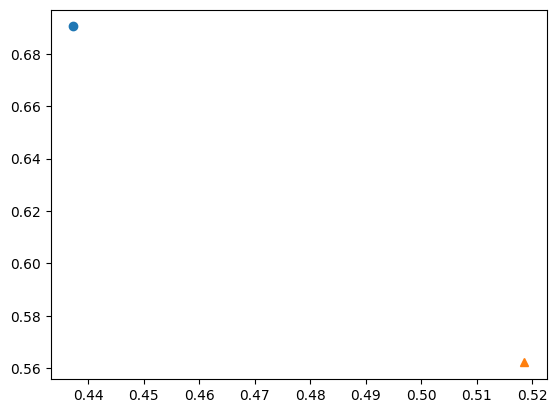

In [11]:
np.savetxt('Solutions.txt', sols, delimiter=', ')   # X is an array

plt.plot(sols[:, 0], sols[:, 1], 'o')
plt.plot(ShF(bestSol), ShM(bestSol), '^')

In [12]:
np.sqrt(best)

0.7508922379727406

In [13]:
# bestSol
print(bestSol.x)

AttributeError: 'numpy.ndarray' object has no attribute 'x'

In [ ]:
#gradient_descent(bestSol.x,calculate_d(bestSol.x), Vf, VfTd, V2f, V2fTd)

#----> 0


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# for i in range(sols):
#     if(sols[i] < 1):
        